In [61]:
from qutip import ptrace, basis, tensor, Qobj, fidelity
from qutip.qip.operations import swap

import numpy as np
from quantum_dynamic_programming import DensityMatrixExponentiation
import matplotlib.pyplot as plt

## Example of how to use DME

In [65]:
k = 3

my_protocol = DensityMatrixExponentiation(theta=np.pi,N=k,num_work_qubits=1,num_instruction_qubits=k,number_muq_per_call=1)
my_protocol.memory_call_circuit(num_instruction_qubits_per_query=k)
print('DME, q0 is target qubit, q1,q2 and q3 are instruction qubit')
print(my_protocol.c.draw())
c = my_protocol.c

DME, q0 is target qubit, q1,q2 and q3 are instruction qubit
q0: ─U───o─U─o─U─o─U─U─o─U─o─U─o─U─U─o─U─o─U─o─U───
q1: ─X─U─Z─U─Z─U─Z─U─M─|───|───|─────|───|───|─────
q2: ─X─────────────U───Z─U─Z─U─Z─U─M─|───|───|─────
q3: ─X───────────────────────────U───Z─U─Z─U─Z─U─M─


## Fidelity with analytic

In [63]:
def compare_dme_analytic(num_iteration,theta):
    my_protocol = DensityMatrixExponentiation(theta=theta,N=num_iteration,num_work_qubits=1,num_instruction_qubits=num_iteration,number_muq_per_call=1)
    my_protocol.memory_call_circuit(num_instruction_qubits_per_query=num_iteration) 
    c = my_protocol.c
    result = c(nshots=1000)
    qibo_state = Qobj(result.state().reshape((2**(num_iteration+1),1)), dims=[[2]*(num_iteration+1),[1]*(num_iteration+1)]).ptrace(0)

    
    delta_SWAP = (swap(2,[0,1])*theta/num_iteration).expm()
    sigma = basis(2,0) * Qobj(np.array([[1, 0]]))
    rho = basis(2,1) * Qobj(np.array([[0, 1]]))
    for i in range(num_iteration):
        current_state = tensor(sigma,rho)
        current_state = (delta_SWAP * tensor(sigma,rho))
        sigma = current_state.ptrace(0)
    qutip_state = sigma/(sigma.norm())

    #delta_SWAP = (swap(2,[0,1])).expm()
    #sigma = basis(2,0) * Qobj(np.array([[1, 0]]))
    #rho = basis(2,1) * Qobj(np.array([[0, 1]]))
    #current_state = tensor(sigma,rho)
    #current_state = (delta_SWAP * tensor(sigma,rho))
    #sigma = current_state.ptrace(0)
    #targeted_final_state = sigma/(sigma.norm())
    
    return(fidelity(qutip_state,qibo_state))#, fidelity(targeted_final_state,qutip_state)

Text(0.5, 1.0, 'Final state after Density Matrix Exponentiation with qibo.models.qdp')

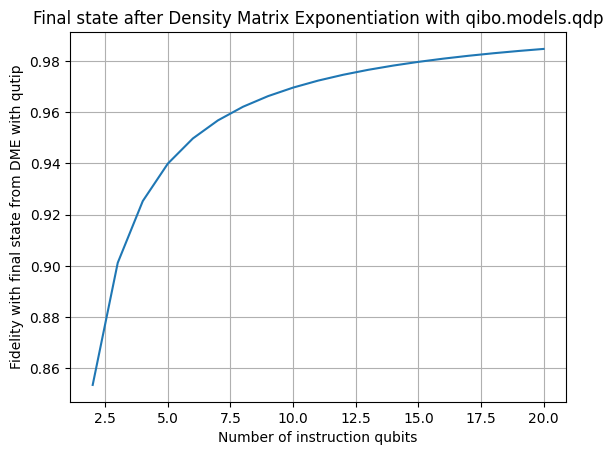

In [64]:
fidelities = []
for i in range(2,21):
    fidelities.append(compare_dme_analytic(i,theta=np.pi/4))

plt.plot(range(2,21),fidelities)
plt.grid()
plt.xlabel('Number of instruction qubits')
plt.ylabel('Fidelity with final state from DME with qutip')
plt.title('Final state after Density Matrix Exponentiation with qibo.models.qdp')